<a href="https://colab.research.google.com/github/smahesh2694/NEU_CLS-64/blob/master/xai_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install -q xlrd

In [0]:
 #!git clone https://smahesh2694:@github.com/smahesh2694/NEU_CLS-64.git

fatal: destination path 'NEU_CLS-64' already exists and is not an empty directory.


In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam

In [4]:
input_sh = (200, 200, 3)

base_model=MobileNet(weights='imagenet',include_top=False, input_shape=input_sh)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



17227776/17225924 [==============================] - 1s 0us/step


In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(9,activation='softmax')(x)

In [0]:
model=Model(inputs=base_model.input, outputs=preds)

In [0]:
base_model.trainable = False #default

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 validation_split=0.2)

In [14]:
train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU-CLS-64', 
                                                 target_size=(200,200),                                                                                                  batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')

Found 5792 images belonging to 9 classes.


In [15]:
val_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU-CLS-64', 
                                                 target_size=(200,200),                                                                                                  batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 1444 images belonging to 9 classes.


In [16]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])

In [0]:
model.summary()

In [0]:
step_size_train=train_generator.n//train_generator.batch_size

step_size_val=val_generator.n//val_generator.batch_size

In [20]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
  6/181 [..............................] - ETA: 41:47 - loss: 1.8893 - acc: 0.4583

KeyboardInterrupt: ignored

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

NameError: ignored

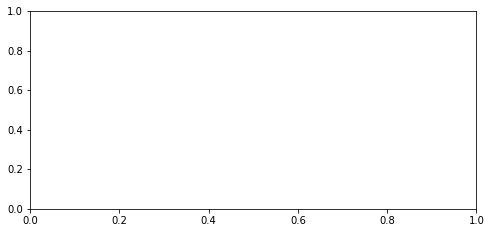

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('/content/drive/My Drive/xai_model/TV_AL_80_20_1.png')


In [0]:
model.save('/content/drive/My Drive/xai_model/model.h5')

In [0]:
model.save_weights('/content/drive/My Drive/xai_model/weights.h5')

In [0]:
lm = load_model('/content/drive/My Drive/xai_model/model.h5')

In [25]:
lm.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 201, 201, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 100, 100, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 100, 100, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 100, 100, 32)      128 